<a href="https://colab.research.google.com/github/KristynaPijackova/Tutorials_NNs_and_signals/blob/main/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly detection with ECG dataset

So in our previous task we used the ECG5000 dataset for a classification task. 

However, as we noticed when analyzing the dataset, the classes are really imbalanced and thus not suitable for classification task. We tried to improve this by creating a synthetic data with SMOTE method (Synthetic Minority Oversampling TEchnique). While this helped us a little bit and we could still see that the underrepresented classes get mixed up with each other. 

Due to the great imbalance of the dataset, it is much better to re-consider our problem and instead of classifying signals which are hugely under-represented, we could try learning features from the strongly represented class and do an anomaly detection instead.



---

Interactive of our example: https://anomagram.fastforwardlabs.com/#/


**Few jupyter notebook shortcuts you can use to make your life easier**

Run cell: `shift + enter`

Undo last action (inside a cell): `ctrl + m + z`

Find and replace: `ctrl + h`

Insert code cell above: `ctrl + a`

Insert code cell below: `ctrl + b`

Delete cell: `ctrl + m + d`

Let's download the data

In [ ]:
! wget http://www.timeseriesclassification.com/Downloads/ECG5000.zip
! unzip ECG5000.zip

--2021-12-18 14:03:39--  http://www.timeseriesclassification.com/Downloads/ECG5000.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 109.123.71.232
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|109.123.71.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10614407 (10M) [application/zip]
Saving to: ‘ECG5000.zip.1’

ECG5000.zip.1       100%[===================>]  10.12M  4.11MB/s    in 2.5s    

2021-12-18 14:03:42 (4.11 MB/s) - ‘ECG5000.zip.1’ saved [10614407/10614407]

Archive:  ECG5000.zip
replace ECG5000.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


And now since we don't need train and test files, we can concatenate the two files together and create one file containing all the data instead.

Here we can simply do this by the the unix command `cat`

In [ ]:
!cat ECG5000_TRAIN.txt ECG5000_TEST.txt > ecg_concat.txt

And we can check if the file-structure still looks the same 

In [ ]:
!head ecg_concat.txt

Let's import libraries we are about to use

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Let's prepare our data

Once again, we create a dataframe with pandas...

In [ ]:
df = pd.read_csv('/content/ecg_concat.txt', sep='  ', header=None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,...,1.173345,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,...,1.557410,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,...,1.640105,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,...,1.553079,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,...,0.982230,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.1

And add prefixes, cause by now we know we cannot work with the column names if they are just numerical...

In [ ]:
df = df.add_prefix('c')
df.columns

Index(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9',
       ...
       'c131', 'c132', 'c133', 'c134', 'c135', 'c136', 'c137', 'c138', 'c139',
       'c140'],
      dtype='object', length=141)

So how many samples in each class do we have now? Let's see...

In [ ]:
df['c0'].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: c0, dtype: int64

### We split the original data into train and test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.values,
                                                    df.values[:,0], 
                                                    test_size=0.2,
                                                    random_state=42)  # by setting random state we will get the same data when recalling the function

### Now we normalize the data

We use MinMaxScaler that was import from sklearn

Here the scaler holds the MinMaxScaler and we fit it on our training data in the second row of the code, which will be applied on the data we want to scale just in a second with `data_scaler.transform(data_we_want_to_scale)`

In [ ]:
scaler = preprocessing.MinMaxScaler()
data_scaler = scaler.fit(x_train[:, 1:])

We take columns 1 to 140 since the 0th column holds the classes and we don't want to change their value.

In [ ]:
x_train[:, 1:] = data_scaler.transform(x_train[:, 1:])
x_test[:, 1:] = data_scaler.transform(x_test[:, 1:])

#### Separate the data into normal and abnormal sets

Well we know we have 5 classes, the first one with index 1 represents normal signals, whilst other 4 represents heart abnormalities.

What we want is to have a class 0 that would represent the normal ECG signals and class 1 that holds all the abnormalities. Once again, pandas functions will help us with this. 

We also don't need the classes - the 0th column, so we take only the columns 1 to 140.

In [ ]:
normal_x_train = pd.DataFrame(x_train).add_prefix('c').query('c0 == 1').values[:,1:]
normal_x_test = pd.DataFrame(x_test).add_prefix('c').query('c0 == 1').values[:,1:]

abnormal_x_train = pd.DataFrame(x_train).add_prefix('c').query('c0 > 1').values[:,1:]
abnormal_x_test = pd.DataFrame(x_test).add_prefix('c').query('c0 > 1').values[:,1:]

**If you are fond of dataframes you could do this instead:**


```
x_train, x_test, y_train, y_test = train_test_split(df.values,
                                                    df.values[:,0], 
                                                    test_size=0.2,
                                                    random_state=42)  # by setting random state we will get the same data when recalling the function
```



Create a dataframe again (optional)...

...once for our original data and then a copy for normalized data (just so you can see the difference here)



```
df_train = pd.DataFrame(x_train).add_prefix('c')
df_test = pd.DataFrame(x_test).add_prefix('c')

df_train_norm = df_train.copy()
df_test_norm = df_test.copy()

scaler = preprocessing.MinMaxScaler()
data_scaler = scaler.fit(x_train[:,1:])


```

And apply it to our data, might seem a bit confusing, so let's see what I did here...

We want to scale the data, not the classes, so we want columns 1 to 140 as 0 holds the classes. For this we use `.iloc[:,1:]` which does exactly what we want, it takes all the row indexes and column indexes 1 to 140. So that's what the left side is doing. 

Now to see what happens on the right side - we take our prepared scaler `data_scaler` use the `.transform()` on it to say we want to transform the data in the brackets. And as on the left side we say that we want to use data from the dataframe in columns 1 to 140 and by adding `.values` we get thir numerical values which we scale. 

Just like that our dataframe is updated with scaled values. 


```
df_train_norm.iloc[:,1:] = data_scaler.transform(df_train_norm.iloc[:,1:].values)
df_test_norm.iloc[:,1:] = data_scaler.transform(df_test_norm.iloc[:,1:].values)
```

Separate the data into normal and abnormal sets

Well we know we have 5 classes, the first one with index 1 represents normal signals, whilst other 4 represents heart abnormalities.

What we want is to have a class 0 that would represent the normal ECG signals and class 1 that holds all the abnormalities. Once again, pandas functions will help us with this. 

```


df_train_normal = df_train_norm.query('c0 == 1')
df_test_normal = df_train_norm.query('c0 == 1')

df_train_abnormal = df_train_norm.query('c0 > 1')
df_test_abnormal = df_train_norm.query('c0 > 1')
```



## Let's look at our data and the difference

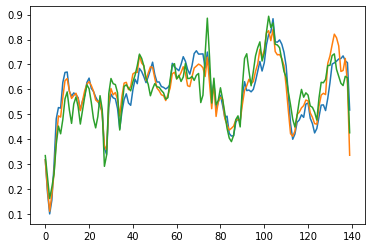

In [ ]:
plt.plot(normal_x_train[0])
plt.plot(normal_x_train[1])
plt.plot(normal_x_train[2])

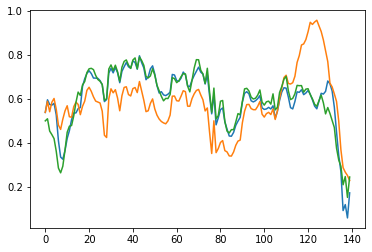

In [ ]:
plt.plot(abnormal_x_train[0])
plt.plot(abnormal_x_train[1])
plt.plot(abnormal_x_train[2])

## Create the autoencoder

In [ ]:
class AutoEncoderDENSE(Model):
    def __init__(self):
        super(AutoEncoderDENSE, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='relu'),])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(140, activation='sigmoid'),])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AutoEncoderDENSE()
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=3,
                    mode='min',)

model.compile(optimizer='adam', loss='mae')

In [ ]:
history = model.fit(normal_x_train, normal_x_train, 
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_train[:,1:], x_train[:,1:]),
                    callbacks=[early_stopping])

Epoch 1/50
19/19 [==============================] - 3s 39ms/step - loss: 0.1144 - val_loss: 0.1017
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0699 - val_loss: 0.0803
Epoch 3/50
19/19 [==============================] - 0s 19ms/step - loss: 0.0505 - val_loss: 0.0763
Epoch 4/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0469 - val_loss: 0.0755
Epoch 5/50
19/19 [==============================] - 0s 22ms/step - loss: 0.0465 - val_loss: 0.0751
Epoch 6/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0464 - val_loss: 0.0752
Epoch 7/50
19/19 [==============================] - 0s 18ms/step - loss: 0.0463 - val_loss: 0.0751
Epoch 8/50
19/19 [==============================] - 0s 22ms/step - loss: 0.0462 - val_loss: 0.0743
Epoch 9/50
19/19 [==============================] - 0s 21ms/step - loss: 0.0461 - val_loss: 0.0743
Epoch 10/50
19/19 [==============================] - 0s 18ms/step - loss: 0.0460 - val_loss: 0.0737
Epoch 11/

## So what did our model learn?

The autoencoder is made of dense layers is trying to learn the distribution of the signal, so it can reproduce it at it's output. 

Since we are training it on the normal data it will learn to reproduce the normal data and will struggle with the abnormalities. 

We pass the normal test data into the model and plot their distribution in comparisson to their original shape. 

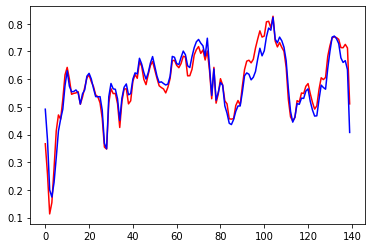

In [ ]:
decoder_out = model(normal_x_test).numpy()

plt.plot(normal_x_test[1], 'r')
plt.plot(decoder_out[1], 'b')

Now we do the same thing, but with the abnormal data.

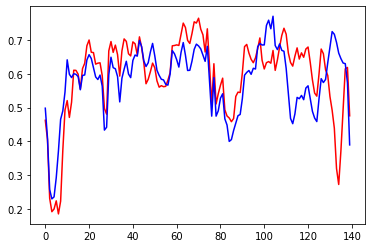

In [ ]:
decoder_out_abnormal = model(abnormal_x_test).numpy()

plt.plot(abnormal_x_test[1], 'r')
plt.plot(decoder_out_abnormal[1], 'b')

## Finding threshold

As we can see, the normal data is fitted pretty accurately, whilst the abnormal data does not really copy the original data. 

And that's what we are focusing at. We can now compute the mean square error `mse` or mean absolute error `mae` of the normal and abnormal data, plot their distribution and based on that decide where the threshold should be, so let's get into it!

#### Normal train data


In [ ]:
reconstruction = model.predict(normal_x_train)
train_loss = tf.keras.losses.mse(reconstruction, normal_x_train) 

Plot the normal data distribution

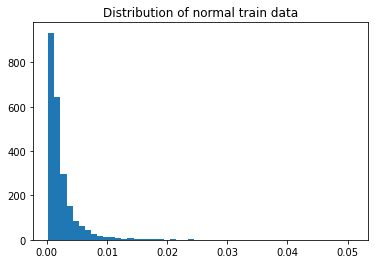

In [ ]:
plt.hist(train_loss, bins=50)
plt.title('Distribution of normal train data')
plt.show()

Get the mean value and standard deviation of the data

In [ ]:
mean_normal = np.mean(train_loss)
mean_normal

0.0024309782558374488

In [ ]:
std_normal = np.std(train_loss)
std_normal

0.0030271994922538795

Let's decide where our threshold is going to be...

We can take the mean value + 2*std and see what we get. 

In [ ]:
threshold = mean_normal + 2*std_normal
threshold

0.008485377240345208

If we look at our histogram, 0.064 seem like a good threshold, where most of our normal data lies on the left side. Now we should see, how the distribution of the abnormal data looks like.

## Evaluation

#### Normal data

Calculate the loss on the testing data and plot the histogram

In [ ]:
reconstruction_test = model.predict(normal_x_test)
test_loss_normal = tf.keras.losses.mse(reconstruction_test, normal_x_test) 

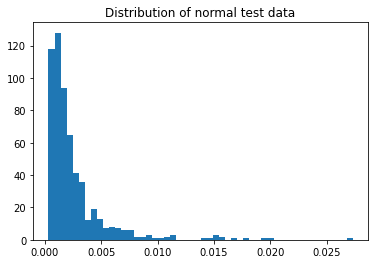

In [ ]:
plt.hist(test_loss_normal, bins=50)
plt.title('Distribution of normal test data')
plt.show()

#### Abnormal data

Again, compute the MAE of the predicted abnormal data and display it in the histogram.

In [ ]:
reconstruction_anomalies = model.predict(abnormal_x_test)
test_loss_anomalies = tf.keras.losses.mse(reconstruction_anomalies, abnormal_x_test)

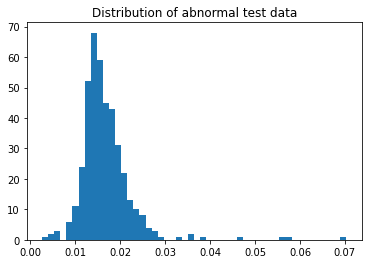

In [ ]:
plt.hist(test_loss_anomalies, bins=50)
plt.title('Distribution of abnormal test data')
plt.show()

Seems like our threshold should work well in detecting the most abnormalities. So let's put it all together.

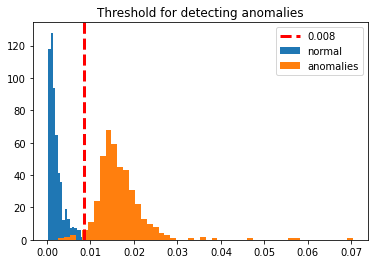

In [ ]:
# plot histograms of normal and abnormal data
plt.hist(test_loss_normal, bins=50, label='normal')
plt.hist(test_loss_anomalies, bins=50, label='anomalies')
# plot a vertical line, which displays the threshold
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
# add a legend and title
plt.legend(loc='upper right')
plt.title('Threshold for detecting anomalies')
plt.show()

## Confusion matrix, ROC curve

To be able to plot the confusion matrix and ROC curve we first need to count how many errors I. and II. we have -> how many false positives or false negatives. 

For this we are going to use the tf.math function, where we compare the threshold with the test losses of normal and abnormal data and get an array with True/False values. 

Next we count how many manu nonzero values we have (non-zero = 1 = True).

In [ ]:
# We correctly detect normal data if the normal loss is smaller than the threshold
pred_normal = tf.math.less(test_loss_normal, threshold)
# We correctly detect abnormal data if the normal loss is greater than the threshold
pred_anomaly = tf.math.greater(test_loss_anomalies, threshold)


In [ ]:
pred_normal_true = tf.math.count_nonzero(pred_normal).numpy()
pred_normal_false = normal_x_test.shape[0] - pred_normal_true
pred_normal_true, pred_normal_false

(562, 24)

In [ ]:
pred_anomaly_true = tf.math.count_nonzero(pred_anomaly).numpy()
pred_anomaly_false = abnormal_x_test.shape[0] - pred_anomaly_true
pred_anomaly_true, pred_anomaly_false

(408, 6)

To **plot the confusion matrix**, we need to create a list which will hold the values we want to display. 

We can also define the categories to display as ticks - normal/anomalities. 

And to plot the data we will use **seaborn**. Seaborn is a library for statistical data visualization and is based on matplotlib, but is more user friendly.
Basicly all we could do is to write sns.heatmap(cm) and we would have our confusion matrix. However we added few extras to make it nice and representable. 

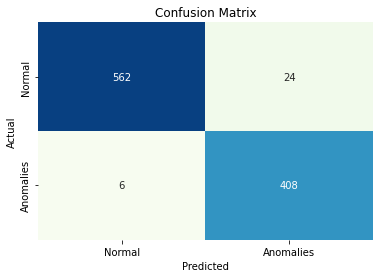

In [ ]:
cm = [[pred_normal_true, pred_normal_false], 
      [pred_anomaly_false, pred_anomaly_true]]

# cm = [[pred_anomaly_true, pred_anomaly_false]
#       [pred_normal_false, pred_normal_true]]

categories = ['Normal', 'Anomalies']

g = sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=categories, 
            yticklabels=categories, 
            cbar=False, 
            cmap="GnBu")

g.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')

plt.show()

Now we combine the first three cells of this block into one as a function which will predict true positives, false negatives, true negatives and false positives. We will need this function to get us values, so we can plot ROC.

In [ ]:
def predictor(normal, abnormal, threshold):
   
    # We correctly detect normal data if the normal loss is smaller than the threshold
    pred_normal = tf.math.less(normal, threshold)
    # We correctly detect abnormal data if the normal loss is greater than the threshold
    pred_anomaly = tf.math.greater(abnormal, threshold)

    tn = tf.math.count_nonzero(pred_normal).numpy()
    fp = normal.shape[0] - tn

    tp = tf.math.count_nonzero(pred_anomaly).numpy()
    fn = abnormal.shape[0] - tp
    
    return tp,tn,fp,fn

Calculate the roc values - tpr and fpr...

...first define empty list which will hold the values

...then create a for loop which will take 100 values from 0 to 1 (use `np.linspace(from, to, steps)`)

...now use the defined predictor function and, where the threshold is the value 0 to 1 of the forloop

...calculate the trp and frp for each iteration `tpr = tp/(tp + fn)` and `fpr = fp/(fp + tn)`

...`append` the tpr and fpr values in the roc list

In [ ]:
tpr_values = []
fpr_values = []

for thresh in np.linspace(0, 1, 100):
    tp,tn,fp,fn = predictor(test_loss_normal, 
                            test_loss_anomalies, 
                            thresh/10)
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    tpr_values.append(tpr)
    fpr_values.append(fpr)

Plot the ROC curve

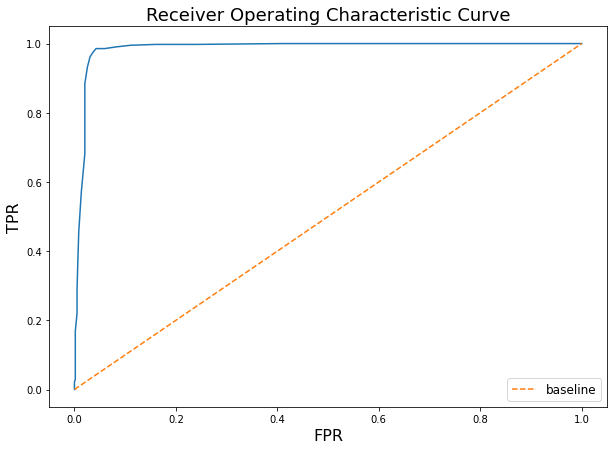

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);